In [1]:
# Data manipulation
from os import path
import numpy as np
import pandas as pd
from itertools import groupby
import os
import csv
import glob
import tifffile
import math

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.colors import ListedColormap
import seaborn as sns
from ipywidgets import interact

# Images manipulation
from skimage import img_as_float, img_as_ubyte, img_as_float64, img_as_float32, exposure, feature, morphology, measure, segmentation, transform, color
from skimage.restoration import denoise_nl_means, unsupervised_wiener, denoise_tv_bregman, denoise_bilateral
from skimage.util import compare_images, invert
from skimage.filters import threshold_multiotsu, difference_of_gaussians
from skimage.morphology import disk
from skimage.registration import phase_cross_correlation
from skimage.io import imread
from scipy import stats, misc, ndimage
import cv2
from skimage.metrics import structural_similarity
from skimage import registration
from skimage.transform import warp
from skimage.measure import marching_cubes

import pickle
import copy

In [2]:
# Parameters 

Inputs = pd.read_excel (r'Inputs_FIB-SEM_ASSB.xlsx')

path_tomo = (Inputs["Parameters' value"][1])
print("Results path = ", path_tomo)

data_format = str(Inputs["Parameters' value"][2])
data_format = "." + data_format
print("data_format = ", data_format)

# Light adjustment
light_adj = (Inputs["Parameters' value"][4])
if light_adj == "No":
    light_adj = 0
else:
    light_adj = 1
print("Light adjustment = ", light_adj)

clip_lim = (Inputs["Parameters' value"][5])
try:
    clip_lim = int(clip_lim)
except:
    clip_lim = 2
print("clip_lim = ", clip_lim)

grid_clahe = (Inputs["Parameters' value"][6])
try:
    grid_clahe = int(grid_clahe)
except:
    grid_clahe = 4
print("grid_clahe = ", grid_clahe)

# Segmentation parameters
k_size_SE = 600 # Not used in this version of the code

thresh_pores = (Inputs["Parameters' value"][8])
try:
    thresh_pores = int(thresh_pores)
except:
    thresh_pores = 140
print("thresh_pores = ", thresh_pores)

vert_lines = (Inputs["Parameters' value"][9])
if vert_lines == "Yes":
    vert_lines = True
else:
    vert_lines = False
print("Remove vertical lines = ", vert_lines)

vert_kernel = 10
orizontal_kernel = 1
try:
    splitted_vert_kernel = Inputs["Parameters' value"][10].split(",")
    vert_kernel = int(splitted_vert_kernel[0])
    orizontal_kernel = int(splitted_vert_kernel[1])
except:
    pass
print("Horizontal kernel = [", vert_kernel, ",", orizontal_kernel, "]")

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (vert_kernel,orizontal_kernel)) # Used only if vert_lines = True

median_smoothing = (Inputs["Parameters' value"][11])
try:
    median_smoothing = int(median_smoothing)
except:
    median_smoothing = 5
print("median smoothing kernel size = ", median_smoothing)


reverse = False

# Interfaces analysis
pixel_lenght = (Inputs["Parameters' value"][13])
try:
    pixel_lenght = float(pixel_lenght)
except:
    pixel_lenght = 0
print("Pixel resolution (nm) = ", pixel_lenght)

regions = (Inputs["Parameters' value"][14])
try:
    regions = int(regions)
except:
    regions = 10
print("Number of regions = ", regions)

Results path =  D:\Teo\Tomography\Tomo\Philip\20211112_JS_NCMMSE_LPSI_3mm\20211112_JS_NCMMSE_LPSI_3mm\Tomo\Test_small
data_format =  .png
Light adjustment =  1
clip_lim =  2
grid_clahe =  4
thresh_pores =  140
Remove vertical lines =  False
Horizontal kernel = [ 10 , 1 ]
median smoothing kernel size =  5
Pixel resolution (nm) =  100.0
Number of regions =  10


In [2]:
def rem_artef_lines(img_i, horizontal_kernel, median_smoothing):
    img_h = cv2.morphologyEx(img_i,cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    img = cv2.medianBlur(img_h, median_smoothing)
    
    return img

In [3]:
def registration_imgs(path_tomo):
    files = os.listdir(path_tomo)

    BSE_images = {}
    for file in files:
        if "BSE" in file and data_format in file:
            num_slice = file.split(data_format)[0].split("-")[-1]
            BSE_images[str(num_slice)] = file

    import warnings
    warnings.filterwarnings("ignore")
    
    path_img_0 = path_tomo + "\\" + str(BSE_images["00001"])
    img_0 = img_as_ubyte(imread((path_img_0), as_gray=True))

    stack = []
    for s in range((len(BSE_images))):
        stack_i = np.zeros((len(img_0), len(img_0[0])))
        stack.append(stack_i)

    count_z = 0
    flows = {}
        
    for key in BSE_images:
        if key != "00001":
            path_img = path_tomo + "\\" + str(BSE_images[key])
            img_original = img_as_ubyte(imread((path_img), as_gray=True))

            count_y = 0
            for y in img_original:
                count_x = 0
                for x in y:
                    stack[count_z][count_y][count_x] = img_original[count_y][count_x]
                    count_x+=1 
                count_y+=1

            img1 = img_original
            img2 = img_original_pre

            flow = registration.optical_flow_tvl1(img2, img1)
            flow_x = flow[1, :, :]
            flow_y = flow[0, :, :]

            name_flow_x = "flow_x_" + str(key)
            name_flow_y = "flow_y_" + str(key)
            flows[name_flow_x] = flow_x
            flows[name_flow_y] = flow_y

            height, width = img2.shape
            row_coords, col_coords = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")

            img1Reg= warp(img1, np.array([(row_coords + flow_y), (col_coords + flow_x)]))

            img_original_pre = img1Reg


        else: 
            path_img = path_tomo + "\\" + str(BSE_images[key])
            img_original = img_as_ubyte(imread((path_img), as_gray=True))

            count_y = 0
            for y in img_original:
                count_x = 0
                for x in y:
                    stack[count_z][count_y][count_x] = img_original[count_y][count_x]
                    count_x+=1 
                count_y+=1

            img_original_pre = img_original

        name_pre = str(BSE_images[key])
        key_pre = key  
        count_z+=1

        print(key, "/", len(BSE_images))
        
    return BSE_images, stack, flows

In [4]:
def cropping(stack, flows):
    max_flow_x = 0
    min_flow_x = 0
    for key in flows:
        if "_x_" in key:
            for y in flows[key]:
                max_i = max(y)
                min_i = min(y)
                if max_i > max_flow_x:
                    max_flow_x = math.ceil(max_i)
                if min_i < min_flow_x:
                    min_flow_x = math.floor(min_i)

    max_flow_y = 0
    min_flow_y = 0
    for key in flows:
        if "_y_" in key:
            for y in flows[key]:
                max_i = max(y)
                min_i = min(y)
                if max_i > max_flow_y:
                    max_flow_y = math.ceil(max_i)
                if min_i < min_flow_y:
                    min_flow_y = math.floor(min_i)

    limit_left = max_flow_x
    limit_right = len(stack[0][0]) - min_flow_x
    limit_top = max_flow_y
    limit_bottom = len(stack[0]) - min_flow_y

    print(limit_left, limit_right, limit_top, limit_bottom)

    # Cropping images
    cropped_stack = []
    for s in range((len(stack))):
        stack_i = np.zeros((len(stack[0]), len(stack[0][0])))
        cropped_stack.append(stack_i)


    for z in range(len(stack)):
        cropped_stack[z] = stack[z][limit_top:limit_bottom, limit_left:limit_right]
        
    return cropped_stack

In [5]:
def segm_AM_SE_pores_tomo(original_img, vert_lines, horizontal_kernel, median_smoothing, k_size_SE, thresh_pores, reverse):
    path_original = "original_image.png"
    cv2.imwrite(path_original, original_img)
    original_img = img_as_ubyte(imread((path_original), as_gray=True))
    NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)
    original_denoised = img_as_ubyte(NLM_denoised)
    ###original_denoised = original_img

    ret, thresh = cv2.threshold(original_denoised,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #print(ret)
    if vert_lines == True:
        AM_i = thresh #(original_denoised >= ret)
        #AM = cv2.medianBlur(AM_i, 9)
        AM_h = cv2.morphologyEx(AM_i,cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
        AM = cv2.medianBlur(AM_h, median_smoothing)
    if vert_lines == False:
        AM = thresh

    s = (len(original_denoised), len(original_denoised[0]),3)
    SE_pores = np.zeros(s)
    yi = 0
    for y in original_denoised:
        xi = 0
        for x in y:
            if AM[yi][xi] == 0:
                SE_pores[yi][xi] = 255
            xi+=1
        yi+=1
    SE_pores = np.uint8(SE_pores)   


    # Getting the SE phase
    img = img_as_ubyte(imread((path_original), as_gray=True))
    SE_gray = original_img
    SE_gray[AM==255] = 0
    #SE_gray = cv2.medianBlur(SE_gray, 9)

    #equalised_SE = img_as_ubyte(exposure.equalize_adapthist(SE_gray, kernel_size = k_size_SE, clip_limit=0.007))

    ksize_Gabor = 90
    theta=np.pi/3
    kernel = cv2.getGaborKernel((ksize_Gabor,ksize_Gabor), 1.0, theta, 10.0, 1.9, 0, ktype=cv2.CV_32F)
    filtered_image = cv2.filter2D(SE_gray,cv2.CV_8UC1, kernel)
    filtered_image[AM==255] = 255
    filtered_image = cv2.medianBlur(filtered_image, 5)
    #filtered_image_m = cv2.medianBlur(filtered_image, 3)

    #thresh_pores = 180
    pore = (filtered_image < thresh_pores)
    pore = np.uint8(pore)


    img = img_as_ubyte(imread((path_original), as_gray=True))
    SE_gray[pore==1] = 0
    SE = SE_gray

    s = (len(original_denoised), len(original_denoised[0]),3)
    segmented_image = np.zeros(s)
    segmented_image = img_as_ubyte(segmented_image)
    yi = 0
    for y in original_denoised:
        xi = 0
        for x in y:
            if pore[yi][xi] == 0:
                segmented_image[yi][xi] = [247,247,247]
            if SE[yi][xi] == 0:
                segmented_image[yi][xi] = [247,247,247]
            if SE[yi][xi] > 0:
                segmented_image[yi][xi] = [239,138,98]
            if AM[yi][xi] == 255:
                segmented_image[yi][xi] = [98,138,239]
            xi+=1
        yi+=1

    if reverse == True:
        SE_i = SE
        AM_i = AM
        AM = SE
        SE = AM

    #fig = plt.figure(figsize=(20,9))
    #ax1 = fig.add_subplot(1,2,1)
    #ax1.imshow(original_denoised, cmap="gray")
    #ax1.title.set_text("Original denoised")
    #ax1 = fig.add_subplot(1,2,2)
    #ax1.imshow(segmented_image, cmap="gray")
    #ax1.title.set_text("Segmented")
    
    os.remove(path_original)
    
    return segmented_image, AM, SE, pore, filtered_image

In [6]:
def interfaces_tomo(segmented_stack, n_regions):

    directory_int = directory_res + "\\" + "Phases and interfaces evolution"
    try: 
        os.makedirs(directory_int)
    except:
        pass

    AM_SE_count = 0
    AM_pore_count = 0
    SE_pore_count = 0

    height_region = math.floor(len(segmented_stack)/n_regions)
    limits_regions = {}
    for r in range(1, n_regions):
        limit_i = r*height_region
        limits_regions[limit_i] = {}
        limits_regions[limit_i]["AM_SE_perc"] = []
        limits_regions[limit_i]["AM_pore_perc"] = []
        limits_regions[limit_i]["SE_pore_perc"] = []
        limits_regions[limit_i]["AM_SE_um"] = []
        limits_regions[limit_i]["AM_pore_um"] = []
        limits_regions[limit_i]["SE_pore_um"] = []
        #limits_regions[limit_i]["Total"] = []

    limit_i = len(segmented_stack)-2 # To understand why I need -2 here, I am not sure
    limits_regions[limit_i] = {}
    limits_regions[limit_i]["AM_SE_perc"] = []
    limits_regions[limit_i]["AM_pore_perc"] = []
    limits_regions[limit_i]["SE_pore_perc"] = []
    limits_regions[limit_i]["AM_SE_um"] = []
    limits_regions[limit_i]["AM_pore_um"] = []
    limits_regions[limit_i]["SE_pore_um"] = []
    
        
    last_total_count = 0
    last_AM_SE_count = 0
    last_AM_pore_count = 0
    last_SE_pore_count = 0
    zc = 0
    for z in segmented_stack:
        segmented_image = z
        yc = 0
        for y in segmented_image:
            xc = 0
            for x in y:
                if segmented_image[yc][xc][0] == 98:
                    try:
                        if segmented_image[yc][xc+1][0] == 239:
                            AM_SE_count+=1
                        if segmented_image[yc+1][xc][0] == 239:
                            AM_SE_count+=1
                        if segmented_stack[zc+1][yc][xc][0] == 239:
                            AM_SE_count+=1
                        if segmented_image[yc][xc+1][0] == 247:
                            AM_pore_count+=1
                        if segmented_image[yc+1][xc][0] == 247:
                            AM_pore_count+=1
                        if segmented_stack[zc+1][yc][xc][0] == 247:
                            AM_pore_count+=1
                    except:
                        continue
                if segmented_image[yc][xc][0] == 239:
                    try:
                        if segmented_image[yc][xc+1][0] == 247:
                            SE_pore_count+=1
                        if segmented_image[yc+1][xc][0] == 247:
                            SE_pore_count+=1
                        if segmented_stack[zc+1][yc][xc][0] == 247:
                            SE_pore_count+=1
                    except:
                        continue
                xc+=1
            yc+=1
        last_lim = 0
        count_l = 0

        for l in limits_regions:
            limit = float(l)
            if zc >= 0 or zc > last_lim:
                if zc <= limit:
                    total_count = AM_SE_count+AM_pore_count+SE_pore_count
                    total_i = total_count-last_total_count
                    AM_SE_count_i = AM_SE_count - last_AM_SE_count
                    AM_pore_count_i = AM_pore_count - last_AM_pore_count
                    SE_pore_count_i = SE_pore_count - last_SE_pore_count 
                    limits_regions[l]["AM_SE_perc"].append(AM_SE_count_i/total_i)
                    limits_regions[l]["AM_pore_perc"].append(AM_pore_count_i/total_i)
                    limits_regions[l]["SE_pore_perc"].append(SE_pore_count_i/total_i)
                    limits_regions[l]["AM_SE_um"].append(AM_SE_count_i*pixel_lenght/1000)
                    limits_regions[l]["AM_pore_um"].append(AM_pore_count_i*pixel_lenght/1000)
                    limits_regions[l]["SE_pore_um"].append(SE_pore_count_i*pixel_lenght/1000)
            last_lim = limit
            count_l+=1
        last_total_count = total_count
        last_AM_SE_count = AM_SE_count
        last_AM_pore_count = AM_pore_count
        last_SE_pore_count = SE_pore_count
        zc+=1

    limits_regions_interfaces = limits_regions

    AM_SE_int_um = AM_SE_count*pixel_lenght/1000
    AM_pore_int_um = AM_pore_count*pixel_lenght/1000
    SE_pore_int_um = SE_pore_count*pixel_lenght/1000

    AM_SE_int_perc = AM_SE_count/(AM_SE_count+AM_pore_count)
    AM_pore_int_perc = AM_pore_count/(AM_SE_count+AM_pore_count)
    SE_pore_int_perc = SE_pore_count/(SE_pore_count+AM_SE_count)
    SE_AM_int_perc = AM_SE_count/(SE_pore_count+AM_SE_count)


    header = ["AM-SE interface (um)", "AM-pore interface (um)", "SE-pore interface (um)"]
    header2 = ["AM-SE interface (%)", "AM-pore interface (%)", "SE-pore  interface (%)", "SE-AM interface (%)"]
    int_umn = [AM_SE_int_um,AM_pore_int_um,SE_pore_int_um]
    int_perc = [AM_SE_int_perc,AM_pore_int_perc,SE_pore_int_perc, SE_AM_int_perc]

    path_phases = directory_int + "\\" + "Overall interfaces.csv"
    with open(path_phases, 'w') as f: 
        write = csv.writer(f)
        write.writerow(header)
        write.writerow(int_umn)
        write.writerow(header2)
        write.writerow(int_perc)

    #print(limits_regions)

    averages_int = {}
    for l in limits_regions: 
        averages_int[l] = {}
        averages_int[l]["AM_SE_perc"] = np.average(limits_regions[l]["AM_SE_perc"])
        averages_int[l]["AM_pore_perc"] = np.average(limits_regions[l]["AM_pore_perc"])
        averages_int[l]["SE_pore_perc"] = np.average(limits_regions[l]["SE_pore_perc"])
        averages_int[l]["AM_SE_perc_std"] = np.std(limits_regions[l]["AM_SE_perc"])
        averages_int[l]["AM_pore_perc_std"] = np.std(limits_regions[l]["AM_pore_perc"])
        averages_int[l]["SE_pore_perc_std"] = np.std(limits_regions[l]["SE_pore_perc"])
        averages_int[l]["AM_SE_um"] = np.average(limits_regions[l]["AM_SE_um"])
        averages_int[l]["AM_pore_um"] = np.average(limits_regions[l]["AM_pore_um"])
        averages_int[l]["SE_pore_um"] = np.average(limits_regions[l]["SE_pore_um"])
        averages_int[l]["AM_SE_um_std"] = np.std(limits_regions[l]["AM_SE_um"])
        averages_int[l]["AM_pore_um_std"] = np.std(limits_regions[l]["AM_pore_um"])
        averages_int[l]["SE_pore_um_std"] = np.std(limits_regions[l]["SE_pore_um"])

    header = ["AM-SE interface (um)", "AM-pore interface (um)", "SE-pore interface (um)",
             "AM-SE interface (um) - std", "AM-pore interface (um) - std", "SE-pore interface (um) - std"]

    path_phases = directory_int + "\\" + "Interfaces evolution - thickness.csv"
    with open(path_phases, 'w') as f: 
        write = csv.writer(f)
        write.writerow(header)
        for l in limits_regions:
            int_umn = [averages_int[l]["AM_SE_um"], averages_int[l]["AM_pore_um"], averages_int[l]["SE_pore_um"],
                      averages_int[l]["AM_SE_um_std"], averages_int[l]["AM_pore_um_std"], averages_int[l]["SE_pore_um_std"]]
            write.writerow(int_umn)

        header2 = ["AM-SE interface (%)", "AM-pore interface (%)", "SE-pore interface (%)",
                  "AM-SE interface (%) - std", "AM-pore interface (%) - std", "SE-pore interface (%) - std"]
        write.writerow(header2)
        for l in limits_regions:
            int_perc = [averages_int[l]["AM_SE_perc"], averages_int[l]["AM_pore_perc"], averages_int[l]["SE_pore_perc"],
                       averages_int[l]["AM_SE_perc_std"], averages_int[l]["AM_pore_perc_std"], averages_int[l]["SE_pore_perc_std"]]
            write.writerow(int_perc)

    percentages = {}
    thicknesses = []
    surfaces = {}

    for t in averages_int:
        thicknesses.append(int(t)*pixel_lenght/1000)

    pec_names = ["AM_SE_perc", "AM_pore_perc", "SE_pore_perc", "AM_SE_perc_std", "AM_pore_perc_std", "SE_pore_perc_std"]
    surf_names = ["AM_SE_um", "AM_pore_um", "SE_pore_um", "AM_SE_um_std", "AM_pore_um_std", "SE_pore_um_std"]

    for p in pec_names:
        percentages[p] = []
        for l in averages_int:
            perc_i = averages_int[l][p]
            percentages[p].append(perc_i)

    for s in surf_names:
        surfaces[s] = []
        for l in averages_int:
            surf_i = averages_int[l][s]
            surfaces[s].append(surf_i)


    pec_names = ["AM_SE_perc", "AM_pore_perc", "SE_pore_perc"]
    surf_names = ["AM_SE_um", "AM_pore_um", "SE_pore_um"]

    title = "Interfaces along electrode thickness (%)"
    fig = plt.figure(figsize=(13, 11))
    plt.title(title)
    count = 0
    for p in pec_names:
        c = count/len(pec_names)
        p_std = p + "_std"
        plt.errorbar(thicknesses, percentages[p], yerr=percentages[p_std], linewidth=2, color=plt.cm.cool(c), label=str(p), marker = "o")
        count+=1
        plt.legend(fontsize=22) #loc='lower left'
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("Electrode thickness (μm)", fontsize=28)
        plt.ylabel("Interfaces surface (%)", fontsize=28) # I am not sure that calculating it this way 
        plot_save = directory_int + "\\" + title + ".png"
        plt.savefig(plot_save)


    title = "Interfaces along electrode thickness (μm)"
    fig = plt.figure(figsize=(13, 11))
    plt.title(title)
    count = 0
    for s in surf_names:
        c = count/len(surf_names)
        s_std = s + "_std"
        plt.errorbar(thicknesses, surfaces[s], yerr=surfaces[s_std], linewidth=2, color=plt.cm.cool(c), label=str(s), marker = "o")
        count+=1
        plt.legend(fontsize=22) #loc='lower left'
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("Electrode thickness (μm)", fontsize=28)
        plt.ylabel("Interfaces surface (μm$^{2}$)", fontsize=28) # I am not sure that calculating it this way 
        plot_save = directory_int + "\\" + title + ".png"
        plt.savefig(plot_save)

    AM_count = 0
    SE_count = 0
    pore_count = 0

    height_region = math.floor(len(segmented_stack)/n_regions)
    limits_regions = {}
    for r in range(1, n_regions):
        limit_i = r*height_region
        limits_regions[limit_i] = {}
        limits_regions[limit_i]["AM_perc"] = []
        limits_regions[limit_i]["pore_perc"] = []
        limits_regions[limit_i]["SE_perc"] = []
        #limits_regions[limit_i]["Total"] = []

    limit_i = len(segmented_stack)
    limits_regions[limit_i] = {}
    limits_regions[limit_i]["AM_perc"] = []
    limits_regions[limit_i]["pore_perc"] = []
    limits_regions[limit_i]["SE_perc"] = []

    last_total_count = 0
    last_AM_count = 0
    last_pore_count = 0
    last_SE_count = 0
    zc = 0
    for z in segmented_stack:
        segmented_image = z
        #print(segmented_image)
        yc = 0
        for y in segmented_image:
            xc = 0
            for x in y:
                if x[0] == 247:
                    pore_count+=1
                if x[0] == 239:
                    SE_count += 1
                if x[0] == 98:
                    AM_count += 1
                xc+=1
            yc+=1
        last_lim = 0
        count_l = 0

        for l in limits_regions:
            limit = float(l)
            if zc >= 0 or zc > last_lim:
                if zc <= limit:
                    total_count = AM_count+pore_count+SE_count
                    total_i = total_count-last_total_count
                    AM_count_i = AM_count - last_AM_count
                    pore_count_i = pore_count - last_pore_count
                    SE_count_i = SE_count - last_SE_count 
                    limits_regions[l]["AM_perc"].append(AM_count_i/total_i)
                    limits_regions[l]["pore_perc"].append(pore_count_i/total_i)
                    limits_regions[l]["SE_perc"].append(SE_count_i/total_i)
            last_lim = limit
            count_l+=1
        last_total_count = total_count
        last_AM_count = AM_count
        last_pore_count = pore_count
        last_SE_count = SE_count
        zc+=1

    averages_int = {}
    for l in limits_regions: 
        averages_int[l] = {}
        averages_int[l]["AM_perc"] = np.average(limits_regions[l]["AM_perc"])
        averages_int[l]["pore_perc"] = np.average(limits_regions[l]["pore_perc"])
        averages_int[l]["SE_perc"] = np.average(limits_regions[l]["SE_perc"])
        averages_int[l]["AM_perc_std"] = np.std(limits_regions[l]["AM_perc"])
        averages_int[l]["pore_perc_std"] = np.std(limits_regions[l]["pore_perc"])
        averages_int[l]["SE_perc_std"] = np.std(limits_regions[l]["SE_perc"])

    header = ["AM", "SE", "pore", "AM_std", "SE_std", "pore_std"]

    path_phases = directory_int + "\\" + "Phases evolution - thickness.csv"
    with open(path_phases, 'w') as f: 
        write = csv.writer(f)
        write.writerow(header)
        for l in averages_int:
            int_perc = [averages_int[l]["AM_perc"], averages_int[l]["SE_perc"], averages_int[l]["pore_perc"],
                      averages_int[l]["AM_perc_std"], averages_int[l]["SE_perc_std"], averages_int[l]["pore_perc_std"]]
            write.writerow(int_perc)

    pec_names = ["AM_perc", "pore_perc", "SE_perc", "AM_perc_std", "pore_perc_std", "SE_perc_std"]

    for p in pec_names:
        percentages[p] = []
        for l in averages_int:
            perc_i = averages_int[l][p]
            percentages[p].append(perc_i)


    pec_names = ["AM_perc", "pore_perc", "SE_perc"]

    title = "Phases evolution along electrode thickness (%)"
    fig = plt.figure(figsize=(13, 11))
    plt.title(title)
    count = 0
    for p in pec_names:
        c = count/len(pec_names)
        p_std = p + "_std"
        plt.errorbar(thicknesses, percentages[p], yerr=percentages[p_std], linewidth=2, color=plt.cm.cool(c), label=str(p), marker = "o")
        count+=1
        plt.legend(fontsize=22) #loc='lower left'
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("Electrode thickness (μm)", fontsize=28)
        plt.ylabel("Volume fraction (%)", fontsize=28)
        plot_save = directory_int + "\\" + title + ".png"
        plt.savefig(plot_save)
    
    return AM_SE_int_um,AM_pore_int_um,SE_pore_int_um, AM_SE_int_perc,AM_pore_int_perc,SE_pore_int_perc, SE_AM_int_perc

In [9]:
# test previous 
previous = 0

path_previous = path_tomo + "\\Results\\Segmented, registered, and cropped"

Samples_dir = [x[0] for x in os.walk(path_tomo)]

if path_previous in Samples_dir:
    previous = 1
    
print("previous = ", previous)

previous =  0


In [10]:
if previous == 0:
    BSE_images, stack, flows = registration_imgs(path_tomo)    

00001 / 442
00002 / 442
00003 / 442
00004 / 442
00005 / 442
00006 / 442
00007 / 442
00008 / 442
00009 / 442
00010 / 442
00011 / 442
00012 / 442
00013 / 442
00014 / 442
00015 / 442
00016 / 442
00017 / 442
00018 / 442
00019 / 442
00020 / 442
00021 / 442
00022 / 442
00023 / 442
00024 / 442
00025 / 442
00026 / 442
00027 / 442
00028 / 442
00029 / 442
00030 / 442
00031 / 442
00032 / 442
00033 / 442
00034 / 442
00035 / 442
00036 / 442
00037 / 442
00038 / 442
00039 / 442
00040 / 442
00041 / 442
00042 / 442
00043 / 442
00044 / 442
00045 / 442
00046 / 442
00047 / 442
00048 / 442
00049 / 442
00050 / 442
00051 / 442
00052 / 442
00053 / 442
00054 / 442
00055 / 442
00056 / 442
00057 / 442
00058 / 442
00059 / 442
00060 / 442
00061 / 442
00062 / 442
00063 / 442
00064 / 442
00065 / 442
00066 / 442
00067 / 442
00068 / 442
00069 / 442
00070 / 442
00071 / 442
00072 / 442
00073 / 442
00074 / 442
00075 / 442
00076 / 442
00077 / 442
00078 / 442
00079 / 442
00080 / 442
00081 / 442
00082 / 442
00083 / 442
0008

In [11]:
if previous == 0:
    cropped_stack = cropping(stack, flows)

138 965 125 909


In [12]:
def registration_check(y):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(stack[y], cmap="gray")
    ax1.title.set_text("Original")
    ax1 = fig.add_subplot(1,2,2)
    ax1.imshow(cropped_stack[y], cmap="gray")
    ax1.title.set_text("Registered and cropped")

In [13]:
if previous == 0:
    interact(registration_check, y=(0, len(stack)-1, 1))

interactive(children=(IntSlider(value=220, description='y', max=441), Output()), _dom_classes=('widget-interac…

In [15]:
# Create folder for results
directory_res = path_tomo + "\\" + "Results"
try: 
    os.makedirs(directory_res)
except:
    pass

In [16]:
# CLAHE (Contrast limited adapted histogram equalization) to diminuish difference in brightness and better distinghuish particles
if light_adj == 1:
    cropped_stack_np = copy.copy(np.uint8(np.array(cropped_stack)))

    light_equilibrated = np.zeros((cropped_stack_np.shape[0],cropped_stack_np.shape[1],cropped_stack_np.shape[2]))
    #print(light_equilibrated.shape)

    for i in range(cropped_stack_np.shape[0]): 
        clahe = cv2.createCLAHE(clipLimit=clip_lim, tileGridSize=(grid_clahe,grid_clahe)) # cliplimit and titleGridSize as expert user parameters -1,2 seems good for my case, but typically values seems to be 3,4
        clahe_img = clahe.apply(cropped_stack_np[i])
        light_equilibrated[i] = clahe_img
        
    for i in range(cropped_stack_np.shape[0]):
        plt.hist(cropped_stack_np[i].flat, bins=200, range=(0,255))
    path_save = directory_res + "\\" + "Brightness distribution before CLAHE.png"
    plt.savefig(path_save, dpi=600)
    
    plt.clf()
    
    for i in range(cropped_stack_np.shape[0]):
        plt.hist(light_equilibrated[i].flat, bins=200, range=(0,255))
    path_save = directory_res + "\\" + "Brightness distribution after CLAHE.png"
    plt.savefig(path_save, dpi=600)
    
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [17]:
# To avoid changing naming afterwards
if light_adj == 1:
    cropped_stack = light_equilibrated
if light_adj == 0:
    light_equilibrated = cropped_stack

In [18]:
def light_check(y):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(1,2,2)
    ax1.imshow(light_equilibrated[y], cmap="gray")
    ax1.title.set_text("Light equilibrated")
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(cropped_stack[y], cmap="gray")
    ax1.title.set_text("Original")

In [19]:
if previous == 0:
    interact(light_check, y=(0, len(stack)-1, 1))

interactive(children=(IntSlider(value=220, description='y', max=441), Output()), _dom_classes=('widget-interac…

In [20]:
# Saving the registered, and cropped images
directory_reg = directory_res + "\\" + "Registered and cropped"
try: 
    os.makedirs(directory_reg)
except:
    pass

if previous == 0:
    count_z = 0
    for z in cropped_stack:
        path = directory_reg + "\\Final_" + str(count_z) + ".png"
        cv2.imwrite(path, cropped_stack[count_z])
        count_z+=1

1 / 442
2 / 442
3 / 442
4 / 442
5 / 442
6 / 442
7 / 442
8 / 442
9 / 442
10 / 442
11 / 442
12 / 442
13 / 442
14 / 442
15 / 442
16 / 442
17 / 442
18 / 442
19 / 442
20 / 442
21 / 442
22 / 442
23 / 442
24 / 442
25 / 442
26 / 442
27 / 442
28 / 442
29 / 442
30 / 442
31 / 442
32 / 442
33 / 442
34 / 442
35 / 442
36 / 442
37 / 442
38 / 442
39 / 442
40 / 442
41 / 442
42 / 442
43 / 442
44 / 442
45 / 442
46 / 442
47 / 442
48 / 442
49 / 442
50 / 442
51 / 442
52 / 442
53 / 442
54 / 442
55 / 442
56 / 442
57 / 442
58 / 442
59 / 442
60 / 442
61 / 442
62 / 442
63 / 442
64 / 442
65 / 442
66 / 442
67 / 442
68 / 442
69 / 442
70 / 442
71 / 442
72 / 442
73 / 442
74 / 442
75 / 442
76 / 442
77 / 442
78 / 442
79 / 442
80 / 442
81 / 442
82 / 442
83 / 442
84 / 442
85 / 442
86 / 442
87 / 442
88 / 442
89 / 442
90 / 442
91 / 442
92 / 442
93 / 442
94 / 442
95 / 442
96 / 442
97 / 442
98 / 442
99 / 442
100 / 442
101 / 442
102 / 442
103 / 442
104 / 442
105 / 442
106 / 442
107 / 442
108 / 442
109 / 442
110 / 442
111 / 44

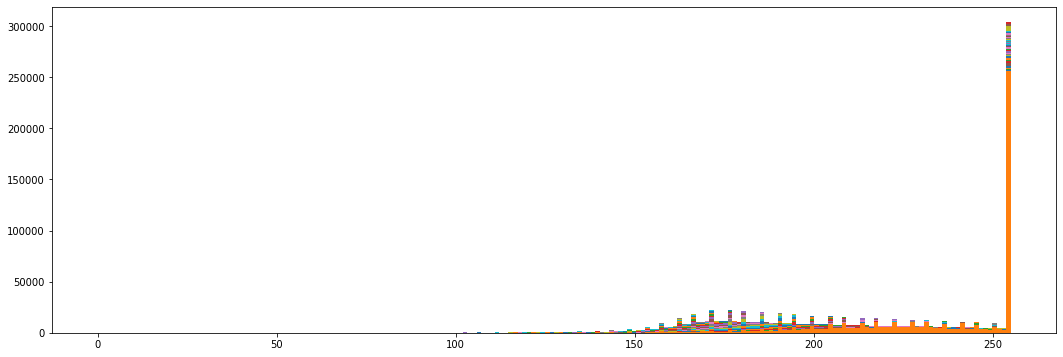

In [21]:
# Segmenting registered image in AM, CBD, and pore phases - Tomo
if previous == 0:
    cropped_segmented = []
    for s in range((len(cropped_stack))):
        stack_i = np.zeros((len(cropped_stack[0]), len(cropped_stack[0][0])))
        cropped_segmented.append(stack_i)

    cropped_AM = []
    for s in range((len(cropped_stack))):
        stack_i = np.zeros((len(cropped_stack[0]), len(cropped_stack[0][0])))
        cropped_AM.append(stack_i)

    cropped_SE = []
    for s in range((len(cropped_stack))):
        stack_i = np.zeros((len(cropped_stack[0]), len(cropped_stack[0][0])))
        cropped_SE.append(stack_i)

    cropped_pores = []
    for s in range((len(cropped_stack))):
        stack_i = np.zeros((len(cropped_stack[0]), len(cropped_stack[0][0])))
        cropped_pores.append(stack_i)

    count_z = 0
    for z in cropped_stack:
        original_img = copy.copy(z)
        segmented_image, AM, SE, pore, filtered_image = segm_AM_SE_pores_tomo(original_img, vert_lines, horizontal_kernel, median_smoothing, k_size_SE, thresh_pores, reverse)
        if count_z == 0:
            f, ax = plt.subplots(figsize=(18,6))
        ax.hist(filtered_image.flat, bins=200, range=(0,255))
        cropped_segmented[count_z] = segmented_image
        cropped_AM[count_z] = AM
        cropped_SE[count_z] = SE
        cropped_pores[count_z] = pore
        count_z+=1
        print(count_z, "/", len(BSE_images))

In [22]:
# Saving the segmented, registered, and cropped images
directory_seg = directory_res + "\\" + "Segmented, registered, and cropped"
try: 
    os.makedirs(directory_seg)
except:
    pass

if previous == 0:
    count_z = 0
    for z in cropped_segmented:
        path = directory_seg + "\\Final_" + str(count_z) + ".png"
        cv2.imwrite(path, cv2.cvtColor(cropped_segmented[count_z], cv2.COLOR_BGR2RGB)) #Check that I need the conversion RGB in PC Lab
        count_z+=1

In [23]:
if previous == 1:
    cropped_segmented = []
    files = os.listdir(path_previous)

    for file in files:
        if ".png" in file:
            path_img = path_previous + "\\" + str(file)
            img = img_as_ubyte(imread(path_img))
            cropped_segmented.append(img)
    
    cropped_segmented = np.array(cropped_segmented)
    
    cropped_stack = []
    path_previous0 = path_tomo + "\\Results\\Registered and cropped"
    files = os.listdir(path_previous0)

    for file in files:
        if ".png" in file:
            path_img = path_previous + "\\" + str(file)
            img = img_as_ubyte(imread(path_img))
            cropped_stack.append(img)
    
    cropped_stack = np.array(cropped_stack)

In [24]:
if previous == 0:
    def crop_segmentation_check(y): # original_stack = cropped_stack
        fig = plt.figure(figsize=(15,7))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(original_stack[y], cmap="gray")
        ax1.title.set_text("Cropped")
        ax1 = fig.add_subplot(1,2,2)
        ax1.imshow(seg_stack[y])
        ax1.title.set_text("Cropped segmented")
        
if previous == 1:
    def crop_segmentation_check(y):
        fig = plt.figure(figsize=(8,7))
        ax1 = fig.add_subplot(1,1,1)
        ax1.imshow(seg_stack[y])
        ax1.title.set_text("Cropped segmented")

In [25]:
seg_stack = cropped_segmented
original_stack = cropped_stack
interact(crop_segmentation_check, y=(0, len(cropped_segmented)-1, 1))

interactive(children=(IntSlider(value=220, description='y', max=441), Output()), _dom_classes=('widget-interac…

<function __main__.crop_segmentation_check(y)>

In [26]:
# Saving as Tiff the segmented stack
path_save = directory_seg + "\\Segmented_original_stack-yzx.tif"
tifffile.imsave(path_save,np.array(cropped_segmented)) 

In [14]:
# Stacking on zyx directions (initial in yzx)

if pixel_lenght > 0:
    stacked_yzx = np.array(cropped_segmented)
    stacked_zyx = []
    for s in range(stacked_yzx.shape[1]):
        stack_i = np.zeros((stacked_yzx.shape[0], stacked_yzx.shape[2]))
        stacked_zyx.append(stack_i)

    for z in range(stacked_yzx.shape[1]):
        stack_ixy = []
        for y in range(stacked_yzx.shape[0]):
            stack_ix = []
            for x in range(stacked_yzx.shape[2]):
                x_i = stacked_yzx[y][z][x]
                stack_ix.append(x_i)
            stack_ixy.append(stack_ix)
        stacked_zyx[z] = stack_ixy
        print(z+1, "\\", stacked_yzx.shape[1])

    stacked_zyx = np.array(stacked_zyx)

    path_save = directory_seg + "\\Segmented_zyx_stack.tif"
    tifffile.imsave(path_save,stacked_zyx) 

    AM_SE_int_um,AM_pore_int_um,SE_pore_int_um, AM_SE_int_perc,AM_pore_int_perc,SE_pore_int_perc,SE_AM_int_perc = interfaces_tomo(stacked_zyx, regions)